In [1]:
import numpy as np
import scipy.sparse as scpsp
import tqdm
import matplotlib.pyplot as plt

In [2]:
# compile C code
import os, ctypes
from ctypes import c_int, c_float
fvec = np.ctypeslib.ndpointer(dtype=np.float32)
ivec = np.ctypeslib.ndpointer(dtype=np.int32)
os.system('gcc -fopenmp -O3 -mavx512f -ffast-math -mtune=native -march=native -c delays2.c -o delays2.c.o')
os.system('gcc -shared -fopenmp delays2.c.o -o delays2.c.so')
lib = ctypes.CDLL('./delays2.c.so')
lib.epi2d_dfun_batch.restype = None
lib.epi2d_dfun_batch.argtypes = (
    c_int, c_int,
    fvec, fvec, fvec, fvec, fvec, fvec, fvec,
    c_float, c_float
)
lib.delays1_batch.restype = None
lib.delays1_batch.argtypes = (
    c_int, c_int, c_int, c_int,
    fvec, fvec, fvec, ivec, ivec, ivec
)
lib.upbuf.restype = None
lib.upbuf.argtypes = (
    c_int, c_int, c_int, c_int,
    fvec, fvec
)
os.environ["OMP_NUM_THREADS"] = "32"

In [3]:
def get_n_excitations(x):
    data_diff = np.diff(x > -1, append=False, axis=0)
    n_excitations = np.ceil(data_diff.sum(axis=0)/2)
    return n_excitations

In [4]:
def heun(bs, nv, nh, i, dxz, xz, dt, x_0, lc, gc, xbuf, k_lc, k_gc, eps, theta, I, W, K, iL, iG):
    # eval coupling 1 or 2, depending on time step
    if i % 2 == 0:
        heavi = np.array(xz[0]>theta,'f') # heaviside step function coupling, upadte the buffer only according to threshold
        lib.upbuf(bs, nv, nh, i, xbuf, heavi) # update buffer
        lib.delays1_batch(bs, nv, nh, i+1, gc[0], xbuf, W.data, iL, W.indices, W.indptr) # global coupling
        lib.delays1_batch(bs, nv, nh, i+1, lc[0], xbuf, K.data, iG, K.indices, K.indptr) # local coupling

        # predictor stage
        lib.epi2d_dfun_batch(bs, nv, dxz[0], xz, lc[1], gc[1], x_0, k_lc, k_gc, eps, I)
        xzi = xz + dt*dxz[0]
        
        # corrector stage
        lib.epi2d_dfun_batch(bs, nv, dxz[1], xzi, lc[0], gc[0], x_0, k_lc, k_gc, eps, I)
        xz += dt/2*(dxz[0] + dxz[1])

    else:
        heavi = np.array(xz[0]>theta,'f') # heaviside step function coupling, upadte the buffer only according to threshold
        lib.upbuf(bs, nv, nh, i, xbuf, heavi) # update buffer
        lib.delays1_batch(bs, nv, nh, i+1, gc[1], xbuf, W.data, iL, W.indices, W.indptr) # global coupling
        lib.delays1_batch(bs, nv, nh, i+1, lc[1], xbuf, K.data, iG, K.indices, K.indptr) # local coupling

        # predictor stage
        lib.epi2d_dfun_batch(bs, nv, dxz[0], xz, lc[0], gc[0], x_0, k_lc, k_gc, eps, I)
        xzi = xz + dt*dxz[0]
        
        # corrector stage
        lib.epi2d_dfun_batch(bs, nv, dxz[1], xzi, lc[1], gc[1], x_0, k_lc, k_gc, eps, I)
        xz += dt/2*(dxz[0] + dxz[1])

In [5]:
def run_sims(dist, gamma_range):
    bs = len(gamma_range) # n sims in parallel

    # create global and local connectivity
    gc_mat = scpsp.csr_matrix([[0,1],[1,0]]).astype('f') 
    lc_mat = scpsp.csr_matrix([[0,1],[1,0]]).astype('f')
    gc_dist_mat = scpsp.csr_matrix([[0,1],[1,0]]).astype('f') * dist
    lc_dist_mat = gc_dist_mat.copy() # irrelevant
    nv = lc_mat.shape[0]

    # some parameters
    dt = np.float32(0.1)

    # prepare extra info for delays
    local_velocity = 6 # # Salami et al. 2002, intra-cortical conduction 10x slower 
    v2v_velocity = 6 #3.9 # according to Lemarechal et al. 2022
    igc = (gc_dist_mat.data / v2v_velocity / dt).astype('i')
    ilc = (lc_dist_mat.data / local_velocity / dt).astype('i')

    # estimate buffer size, use next power of 2 of max delay
    nh_g = 2**int(np.ceil(np.log2( igc.max() + 1 )))
    nh_l = 2**int(np.ceil(np.log2( ilc.max() + 1 )))
    nh = np.max([nh_g, nh_l])

    # allocate buffers
    xbuf = np.zeros((nv, nh, bs), 'f')  #-1.337896365956364   # initialise on fixed point
    dxz = np.zeros((2, 2, nv, bs), 'f')
    xz = np.zeros((2, nv, bs), 'f')
    xz[0,:] = -1.337896365956364
    xz[1,:] = -0.18514344764362828 # initialise on fixed point
    xz[1,1] = -0.3 # initialise some vertices slightly below fixed point so it triggers one oscillation

    lc = np.zeros((2, nv, bs), 'f')
    gc = np.zeros((2, nv, bs), 'f')

    I=np.float32(1.0)
    eps=np.float32(0.04)
    theta=np.float32(0.0)
    gamma_lc = np.array([0.0],'f').repeat(bs) # ignore local coupling i.e. =0
    gamma_gc = np.array(gamma_range,'f')
    x_0 = np.ones((nv, bs),"f") * -1.291610504045457 # set all vertices in excitable regime, won't oscillate on its own

    nskip = 10
    niter = 10000
    c = 0
    x_trace = np.zeros((int(niter/nskip), nv, bs))
    for i in tqdm.trange(niter):
        heun(bs, nv, nh, i, dxz, xz, dt, x_0, lc, gc, xbuf, gamma_lc, gamma_gc, eps, theta, I, gc_mat, lc_mat, igc, ilc)
        if i % nskip == 0:
            x_trace[c,:,:] = xz[0,:,:].copy()
            c += 1

    n_excitations = get_n_excitations(x_trace)    
    return n_excitations


In [6]:
distance_range = np.arange(40,150.1,0.5)
distance_range.shape

(221,)

In [7]:
# small parameter sweep
distance_range = np.arange(40,150.1,5)
gamma_gc_range = np.arange(0.04, 0.2, 0.0005)
n_excitations = np.zeros((len(distance_range),2,len(gamma_gc_range)))
for i,d in enumerate(distance_range):
    n_excitations[i,:,:] = run_sims(d, gamma_gc_range)


 12%|█▏        | 1223/10000 [00:00<00:02, 4220.11it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4633.37it/s]


/tmp/ipykernel_49353/265848736.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(distance_range, gamma_gc_range, n_excitations[:,0,:].T)


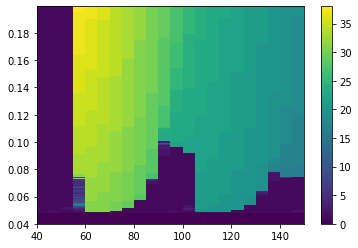

In [8]:
plt.pcolormesh(distance_range, gamma_gc_range, n_excitations[:,0,:].T)
plt.colorbar()

In [9]:
np.savez_compressed("n_excitaions_sweep_two_nodes_cpu", n_excitations=n_excitations, distance_range=distance_range, gamma_gc_range=gamma_gc_range)


 # compare CPU vs GPU results

In [10]:
n_excitaitons_cpu = np.load("n_excitaions_sweep_two_nodes_cpu.npz")['n_excitations']
n_excitaitons_gpu = np.load("n_excitaions_sweep_two_nodes_gpu.npz")['n_excitations']

In [11]:
n_excitaitons_gpu.shape

(23, 640)

In [12]:
n_excitaitons_cpu.shape

(23, 2, 320)

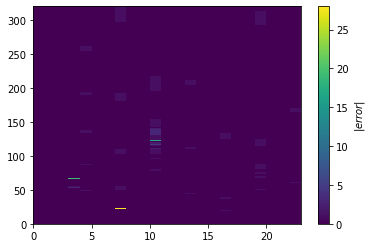

In [13]:
plt.pcolormesh(np.abs(n_excitaitons_cpu[:,1,:].T-n_excitaitons_gpu[:,:len(gamma_gc_range)].T))
plt.colorbar(label="$|error|$")